# **Basic Network Analysis Tutorial**
*08.08.2017*

Update: 
* added Community Detection!
* fixed formatting issues

......................................
* added Elevation and Temporal Travel Dependencies
* Fixed some minor errors
* added formulars


# Table of Contents

1. Introduction
2. Fundamental Graph Theory
3. Network Properties
4. Network Robustness
5. Community Detection
6. Application: Competition 
7. Summary and Outlook
8. References

# 1. Introduction

Welcome to this short introduction on how to use Network Analysis for this competition.
 Gain a deeper understanding of why certain taxis may have a longer trip duration than others and how to extract some useful features for your machine learning algorithm, e.g., calculate the shortest path between the pickup and dropoff point and given that, which Boroughs & Neighborhoods does the taxi traverse?  Are there any 'sensitive' roads on the path of a given taxi which may cause a longer trip time? These and more questions can be addressed by a network analysis. 

This notebook uses graph data from this [dataset](https://www.kaggle.com/crailtap/street-network-of-new-york-in-graphml) , specific it makes use of the Manhattan subgraph, because computation times on the full graph would be to long for Kaggle Kernels. 

Also i would like to encourage you to check out the awesome [OSMNX package](https://github.com/gboeing/osmnx)
from which i extracted the dataset and from which i make use of some functions. It is not available on Kaggle because it needs a Internet connection to download the graphs.

The rest of the notebook is structured as follows: First we take a look at some basic properties of the network, like how big is the network and start digging deeper to explore the generative process of the network and which roads may be important in a sense of high traffic volume and under the aspect of road closures aka attacks. Finally we will calculate useful features for the competition, like shortest paths and which boroughs it passes.

Here is a sneak peak of the raw New York City Street Network!



![](http://i.imgur.com/6YJ6gV3.jpg)

# 2. Fundamental Graph Theory

In this and the following sections, we will introduce some basic terminology of graph theory and try to illustrate those on the New York City Street Network or the Manhattan subgraph. 
We will start by defining the fundamental definition, what is a graph?

A graph **G = (V, E)**  consists of a set of **nodes** V ( or vertices, points)  and a set of **edges**  E ( links, lines) which illustrate how the nodes in the network are interacting with each other. Edges can be **directed** or ** undirected**. The number of nodes **N** is often called the **size** of the network and  states the number of objects in the model. In this example nodes are represented by way points in the OSM map from which the graph was generated, e.g., crossings and edges are roads or sub parts of roads between two nodes.

Each node or edge can hold different attributes, e.g., nodes can be assigned to different types like crossings or dead-ends and edges might have a certain numerical attribute like a speed limit. Edges attributes, in the case of numerical attributes, are called weights. An graph with weighted edges is called an **weighted graph**.

A first measurement for a node in the graph is the so called **degree**, which stands for the number of edges it has to other nodes, denoted by *k*.  One can also might ask what is the average degree in the network? But wait a second... if the degree is the number of edges it has to other nodes, don't we have to distinguish between directed and undirected edges to calculate the degree? Indeed, we need to distiguish between the **In-degree** and the **Out-degree** of a node, simply measuring how many edges are leaving a node and how many edges are coming in. This of cource depends on if the graph is direted or not. In the case of an undirected graph we can calculate the **average degree** by the following formular:

$$ (k) = \frac{1}{N} \sum_{i = 1}^N k_i = \frac{2E}{N}$$

Similar this can be done seperatly for the in- and out-degree:

$$ (k^{in}) = \frac{1}{N} \sum_{i = 1}^N k^{in}_i =(k^{out}) = \frac{1}{N} \sum_{i = 1}^N k^{out}_i =  \frac{E}{V}$$

because $$k_i = k^{out}_i  + k^{in}_i  $$

Let's have a first look at the network (or you can call it graph) and the basic properties of it. But first we need to load the graph and import a library which is capable of doing so. In this Notebook we use networkx as the graph computing library but there are many more: [igraph](http://igraph.org/redirect.html), [osmnx](https://github.com/gboeing/osmnx) or [SNAP](http://snap.stanford.edu/). 

In [2]:
#For later use
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import networkx as nx
warnings.filterwarnings('ignore')

#load the graph with nx.read_graphml
G = nx.read_graphml('newyork.graphml')

/Users/jennwon/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jennwon/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jennwon/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
print(nx.info(G))

Name: New York, USA
Type: MultiDiGraph
Number of nodes: 54128
Number of edges: 142123
Average in degree:   2.6257
Average out degree:   2.6257


The graph has *4426* nodes and *9626* edges so the size of the network is *4426* and it states that it is an MultiDIGraph, which means the edges of the graph are **directed**, so they point to a specific node in the network. 

Why is this so? Because our Network is the Manhattan Street Network and one property of it is that it contains one-way streets which can only be modeled as directed edges. Because we represent the edges as directed each 'normal' street is now also modeled as a directed edge which means we need to introduce two edges for each normal street, one for each direction of the street.

 On average the In-degree is *2.17* and the out-degree is also *2.17*, both are the same just as discussed. Average In-degree and Out-degree are always the same, but the distribution of the individual degrees can vary. To mention here is that just like for the degree, some graph porperties are defined on either directed or undirected some can be translated to both, so in order to calculate some measurements we provide also an undirected graph for the Manhattan network simply by calling the build in graph function from networkx. A graph is often called **simple graph**, if it contains no self-loops and directed edges.

In [4]:
G_simple = nx.Graph(G)
print(nx.info(G_simple))

Name: New York, USA
Type: Graph
Number of nodes: 54128
Number of edges: 89618
Average degree:   3.3113


Interesting! The number of nodes is still *4426* but the number of edges is decreased to only *788* edges. Also the degree went up to *3.56*. One should not be surprised why the new degree is not just in + out-degree, the simplified network merged multiple edges between two nodes to reduce itself into a undirected network, but for a directed network one can always state degree, in-degree and out-degree!  Indeed his degree seems more convenient, because of the grid like structure in Manhattan. 
So let's have a close look on the distribution of the node degress of our graph for simplified network as for the directed case.

In [5]:
def get_degree_dict(degree_tuple):
    degrees= []
    for node, degree in degree_tuple:
        degrees.append(degree)
    return Counter(degrees)

In [6]:
G.degree()

DiMultiDegreeView({'42467330': 8, '42467331': 6, '42467333': 6, '42467334': 8, '42467335': 6, '42467337': 6, '42991626': 6, '42467339': 6, '42860546': 8, '42991630': 5, '42467343': 6, '42467346': 6, '42860563': 6, '42467350': 6, '42991641': 5, '42860570': 6, '42467355': 8, '42991645': 6, '42467360': 6, '42860580': 8, '42467369': 4, '42860586': 6, '42467372': 6, '42467374': 3, '42860591': 6, '42991666': 6, '42860595': 6, '42860598': 6, '42860601': 6, '42860603': 8, '42860605': 6, '42860609': 6, '42729538': 6, '42467396': 5, '42860613': 6, '42860615': 6, '42860617': 8, '42860618': 10, '42467403': 5, '42467405': 3, '42860622': 6, '2757492815': 4, '42860624': 6, '42991698': 6, '42991702': 6, '598321849': 3, '42467417': 3, '42860635': 6, '42445498': 4, '42991710': 6, '42467425': 4, '42838715': 6, '280232037': 6, '42991718': 6, '42467431': 4, '42467435': 4, '42467437': 4, '42991727': 7, '42860656': 4, '2024822120': 4, '42467443': 4, '42991732': 8, '42860663': 3, '42467448': 5, '42467452': 3,

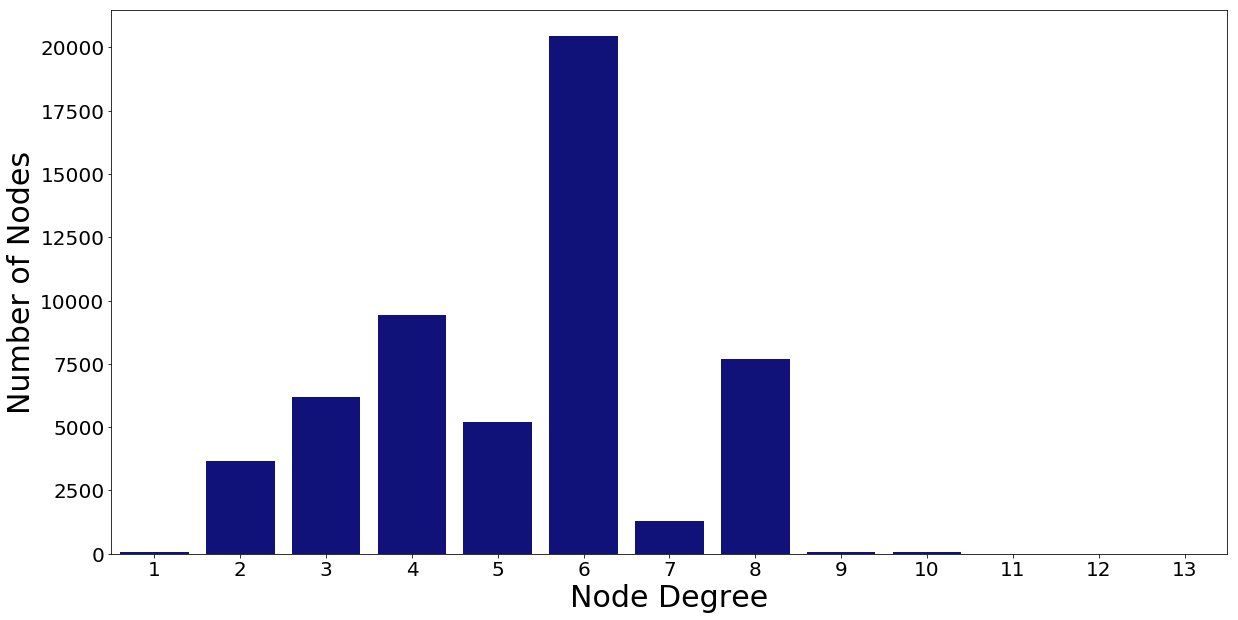

In [9]:
from collections import Counter
#degree_dic = Counter(G.degree().values) #creates a dictionary of all the degrees in the network

# degrees = []
# for node in G.degree():
#     node, degree = node
#     degrees.append(degree)
degree_dic = get_degree_dict(G.degree())


degree_hist = pd.DataFrame({"degree": list(degree_dic.values()),
                            "Number of Nodes": list(degree_dic.keys())})


plt.figure(figsize=(20,10))
sns.barplot(y = 'degree', x = 'Number of Nodes', 
              data = degree_hist, 
              color = 'darkblue')


plt.xlabel('Node Degree', fontsize=30)
plt.ylabel('Number of Nodes', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

Ok, so most of the nodes tend to have a degree of *3* or *4* which comes from the grid like structure of Manhattan. And this is confirmed by plotting the distributions for the directed case, most nodes with 2 outgoing edges have also two incoming edges!

In [14]:
def get_degree_list(degree_tuple):
    degrees= []
    for node, degree in degree_tuple:
        degrees.append(degree)
    return (degrees)


ins = list(get_degree_list(G.in_degree()))
outs = list(get_degree_list(G.out_degree()))

In [15]:
print(len(ins), len(outs))

54128 54128


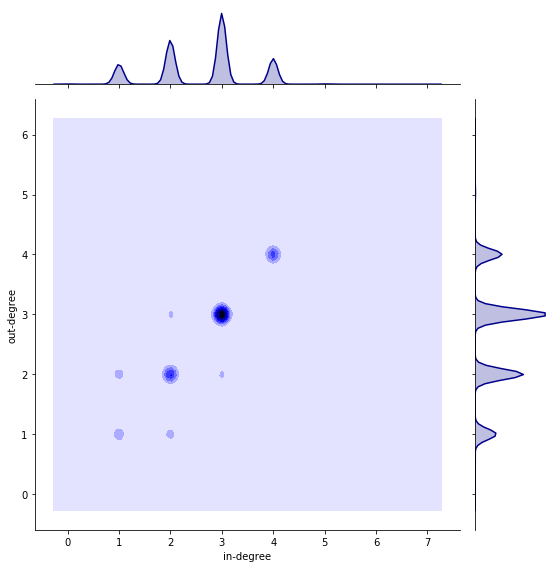

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# ins = list((G.in_degree()).values())
# outs = list((G.out_degree()).values())
degrees = pd.DataFrame({"in-degree": ins, "out-degree": outs})

fig = sns.jointplot(x="in-degree",y="out-degree",data=degrees,kind="kde", color = 'darkblue',size=8)


Given the number of nodes and edges one can ask, what is the structure of the network and how does it look like?
A first measure of the structure of a network is the so called **density** which measure how many links from all possible links within the network are realized. The density is *0* if there are no edges, called **empty graph** and *1* if we have a **complete Graph**, all possible links between nodes are established.

$$dens_{undirected} = \frac{2E}{N(N-1)}$$

$$dens_{directed} = \frac{E}{N(N-1)}$$


In [19]:
nx.density(G)

4.8509682134299694e-05

Having a density of *0.00049* makes sense because in a street network not all nodes can be connected to all other nodes.  Enough text for now, let's plot the graph!

In [27]:
# import osmnx 
# ox.plot_graph(G,fig_height= 12, node_size=10, node_zorder=2, node_color = '#808080')

![](http://i.imgur.com/N9RIXA2.png)

Nice! This gives us a nice overview of how Manhattan looks like. But such awesome figures like this made with osmnx are not always the case. If we plot the graph with the build in draw function from networkx, our nodes are just plotting according to some layout we choose:

In [28]:
nx.draw(G, pos=nx.spring_layout(G), node_size=0.01, width=0.1)

KeyboardInterrupt: 

Wow, doesn't look much like the Manhattan street network right? One should keep in mind to never trust a graph Visualization as it can lead to false impressions on the properties of the graph. Talking about properties, what attributes do our nodes have? 

In [29]:
# we cant not just access the nodes with G(0) orso, we must call them by their id
# G.nodes() returns a list of all node ids, e.g., '42459137'

G[G.nodes()[1]]

KeyError: 1

Each node is a dictionary containing nodes to which it is connected with properties as how many lanes the street has, if it is a oneway street or not, the name of the street and in some cases even the maximum allowed speed.



# 3. Network Properties

In this section we will talk about some basic measurements which will give us some feedback about the structure of the graph. This will include what is the average shortest path distance between nodes, in which way are the nodes in the network connected to each other and how strong is the connection between a node and his neighbours.

We will start by defining what the **shortest path** between two nodes *i* and *j*  in the network is. 
The shortest path *d(i,j)*, as the name suggests, is just the path in the network between nodes  *i* and *j* which has the fewest edges. In the case of an undirected network, the shortest path between *i* and *j* is always the same regardless from which node we start, however in an directed network this does not hold true and the shortest path between the nodes can vary depending from which node we start. On the bases of the shortest path we can define many more measurements, e.g., the longest shortest path in the network is called the **diameter** of the graph and gives us a feeling of how far things are seperated in the graph. We will compute the diameter on the simple graph for computation time.


In [30]:
        nx.diameter(G_simple)

KeyboardInterrupt: 

The function returns a number of *88* edges which lie on the longest shortest path.
Besides the longest shortest path we can also ask what is the average shortest path length denoted by: 

$$ a =  \sum_{i ,j \in E} \frac{d(i,j)}{N(N-1)}$$, where *d(i,j)*  is the shortest path.

In [34]:
nx.average_shortest_path_length(G_simple)

KeyboardInterrupt: 

Coming back to the question of what is the structure of our network, one can ask what is the generative process behind the network? Is the network random? or does it follow some underlying laws on how it is created.

Here we introduce the **Scale-Free Property**, which states that 'real' networks do have a certain underlying creation process, like the WWW there some nodes do get more attention than others and therefore manage to build much more edges than other nodes., resulting in some nodes which have a much higher degree compared to other nodes. 

These nodes with a very high degree in the network are called **hubs**. One can think of Twitter as a Social Network there prominent people represent hubs, having much more edges to other nodes than the average user.
But does our network follow the Scale-Free Property because it is a 'real' network? Let's plot the degree distributions to find out!

In [7]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [37]:
in_degrees  = G.in_degree()
type(in_degrees)
in_h = Counter([degrees for node, degrees in G.in_degree()])

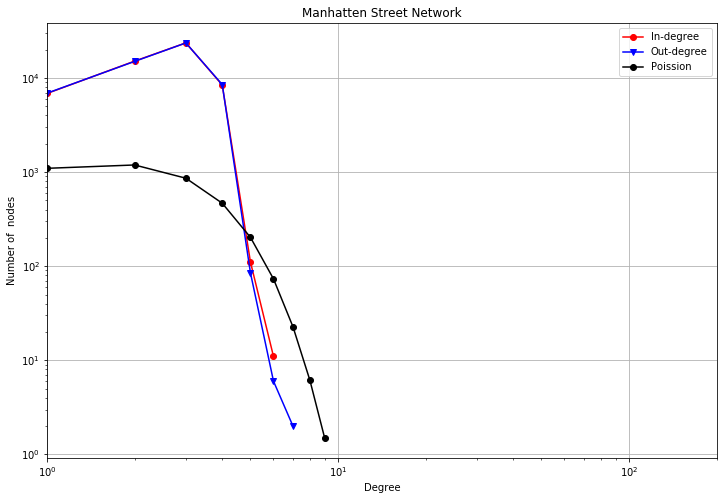

In [39]:
from collections import Counter
import collections
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt

in_degrees  = G.in_degree() 
# in_h = Counter(in_degrees.values())
in_h = Counter([degrees for _, degrees in G.in_degree()])
in_dic = collections.OrderedDict(sorted(in_h.items()))
in_hist = list(in_dic.values())
in_values =list(in_dic.keys())

out_degrees  = G.out_degree() 
# out_h =  Counter(out_degrees.values())
out_h = Counter([degrees for _, degrees in G.out_degree()])
out_dic = collections.OrderedDict(sorted(out_h.items()))
out_hist = list(out_dic.values())
out_values =list(out_dic.keys())

mu = 2.17
sigma = sp.sqrt(mu)
mu_plus_sigma = mu + sigma
x = range(0,10)
prob = stats.poisson.pmf(x, mu)*4426

plt.figure(figsize=(12, 8)) 
plt.grid(True)
plt.loglog(out_values,out_hist,'ro-')  # in-degree
plt.loglog(in_values,in_hist,'bv-')  # in-degree
plt.plot(x, prob, "o-", color="black")
plt.legend(['In-degree','Out-degree','Poission'])
plt.xlabel('Degree')
plt.ylabel('Number of  nodes')
plt.title('Manhatten Street Network')
plt.xlim([0,2*10**2])
plt.show()


If a graphs degree distribution follows the scale free property on a log-log scale plot like above, the data points should form approximately a straight line indicating the presents of hubs. In our figure in the cell above this is clearly not the case. As already plotted, the degree distributions follow a Poisson Distribution which is typical for a random network. 

So what can we say about the Manhattan Street Network? It has more edges than nodes, and the fact that it is not scale-free means the absents of hub nodes and it follows a Poisson Distribution like random networks do.

Now we can ask the question, is it good for a road network that its degree distribution does not have the scale free property and is even random? How does this influences the **robustness** of the network in a sense that what happens if specific roads are closed, how does this influnces the traffic flow?




# 4. Network Robustness

What does it take to break down  all the movement in Manhattan? What roads are sensible in a sense that if these roads are closed the impact on the whole network traffic flow is drastic. Network Robustness tries to define measurements which try to capture how robust  a network is to attacks, failures or something like a traffic jam. 

In this section some basic measurements will be introduced and tested on the Manhattan subgraph.



### Node Connectivity

The **Node Connectivity** describes the number of nodes we must delete from the Graph G until it is **disconnected**. **Connected** means that if every node in our graph G can reach any other node in the network via edges. If this is not the case the graph is disconnected. An important property of any graph should to be that it is not easily to disconnect. This is some kind of vague definition, especially for a road network  as there might be dead-end roads, removing the connecting node of the dead-end would immediately make our graph G disconnected. 

Here it is time in introduce also the notation of a **simple graph** which is a graph without directed edges or self-loops.  Many measurements in libraries are only calculated on simple graphs because it simplifies calculations or the measurements are just not defined on directed graphs.

For the next few sections we treat our graph as undirected to illustrate these measurements:

In [41]:
#create two simple graphs from our original directed graph
G_simple = nx.Graph(G)
G_simple2 = nx.Graph(G)

In [42]:
nx.node_connectivity(G_simple) #lmao this takes so long to run fml

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/jennwon/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-66f462c51f99>", line 1, in <module>
    nx.node_connectivity(G_simple)
  File "/Users/jennwon/anaconda3/lib/python3.6/site-packages/networkx/algorithms/connectivity/connectivity.py", line 342, in node_connectivity
    K = min(K, local_node_connectivity(G, v, w, **kwargs))
  File "/Users/jennwon/anaconda3/lib/python3.6/site-packages/networkx/algorithms/connectivity/connectivity.py", line 210, in local_node_connectivity
    return nx.maximum_flow_value(H, '%sB' % mapping[s], '%sA' % mapping[t], **kwargs)
  File "/Users/jennwon/anaconda3/lib/python3.6/site-packages/networkx/algorithms/flow/maxflow.py", line 308, in maximum_flow_value
    R = flow_func(flowG, _s, _t, capacity=capacity, value_only=True, **kwargs)
  File "/Users/jennwon/anaconda3/lib/python3.6/s

KeyboardInterrupt: 

As aspected the output of  the node connectivity function is 1, meaning our graph is disconnected after removing just 1 node. But does this matter? No, because the size of the removed subgraph is just a single node and the rest of the network is still connected. If however the size of the resulting disconnected part is relatively big, this indicates a problem in the structure of the network.

### Algebraic Connectivity

Basically our network is nothing else as a matrix containing 1's if two nodes are connected to each other.
Graphs can be differently defined as matrices and one of these matrices is the so called Laplacian matrix, which has special properties in the eigenspace. Its eigenvalues are non negative and if ordered the smallest one eigenvalue is zero. The second smallest eigenvalue of the Laplacian matrix is called the **algebraic connectivity** or the **Fiedler value**. It is directly indicater for the robustness of the network have the properties that:
 

 1. The algebraic connectivity is equal to zero if and only if the graph is disconnected.
 2. The algebraic connectivity of an  graph is not greater than the node connectivity. 

In [ ]:
nx.algebraic_connectivity(G_simple)

According to its properties we can say, that the graph is connected because the algebraic connectivity is *0.00034* and < node connectivity.

### Betweenness Centrality

Betweenness Centrality can be measure for nodes or edges and it defines the fraction of all shortest paths in the network passing through the edge/ node for which it is calculated.  

Roads with a very high betweenness centrality lie on many shortest paths in the network and should be considered to be important roads in the network which may have increased traffic volume. 


In [ ]:
#compute the betweeness centrality on one of the simple graphs, this can take a while
between =  nx.betweenness_centrality(G_simple)

In the cell above we created two simple graphs and calculated the betweeness-centrality for each node in the network. We can now tell which nodes in the network play an important role as they are traversed more often. Let's find out which is on the most shortest path in the network: 

In [ ]:
#G_projected = ox.project_graph(G)
#max_node, max_bc = max(between.items(), key=lambda x: x[1])
#max_node, max_bc

(42431099, 0.2170387058765219)

In Manhatten the node with ID 42431099 has  the highest betweenness centrality and 21.7% of all shortest paths running through it. This needs to be plotted!

![](http://i.imgur.com/fnNk9Zf.png)

In [ ]:
G['42431099']

So the node  with the highest betweenness centrality is located in West End!

Now it may be interesting so see how all nodes betweenness centrality looks an one map and maybe there are some patterns  to detect! We plot the centrality for each node from low (dark violet) to high (light yellow).

![](http://i.imgur.com/BfvPPMS.png)

![](http://i.imgur.com/aSCjx77.jpg)

#Network Attacks

Now we know some basic robustness measurements, so it is time to see how robust is our network really?
For this we will attack the networks nodes with two approaches:

 1.  Delete nodes according to the calculated betweenness centrality, going from high scoring nodes to low scoring ones 
 2.  Random node failures, deleting nodes by random

Deleting nodes will have the effect that the **giant component**, the largest connected component in the graph, will shrink and some nodes might have a specific role in this process which cause a drastic shrinkage of the giant component.


In [ ]:
'''
import operator
from random import shuffle
from random import randrange
from random import randint
import random
import matplotlib.ticker as mtick

sorted_x = sorted(between.items(), key=operator.itemgetter(1), reverse=True)
rand_x = list(range(0,4426 ))

random.shuffle(rand_x)
between_giant = []
between_rand = []
avg_degs = []

for x in range(3000):
 
        remove = sorted_x[x]      
        remove2 = sorted_x[rand_x[x]]
        G_simple.remove_nodes_from(remove)
        G_simple2.remove_nodes_from(remove2)
             
        giant = len(max(nx.connected_component_subgraphs(G_simple), key=len))
        giant2 = len(max(nx.connected_component_subgraphs(G_simple2), key=len))

        between_giant.append(giant)
        between_rand.append(giant2)

y1 = between_giant
y2 = between_giant

y1= y1[ :-1]
y2= y2[1: ]

perc = np.linspace(0,100,len(between_giant))
fig = plt.figure(1, (12,8))
ax = fig.add_subplot(1,1,1)

ax.plot(perc, between_giant)
ax.plot(perc, between_rand)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
ax.set_xlabel('Fraction of Nodes Removed')
ax.set_ylabel('Giant Component Size')
ax.legend(['betweenness','random'])
plt.show()
'''

![](http://i.imgur.com/78lVvsQ.png)

Ok, what does the figure above tells us? First of all, deleting nodes which play an important role in the network leads to a faster shrinkage of the giant component than just deleting nodes by random! But only at a given percentage level! At the beginning it doesn't matter if the nodes are picked at random or by their importance, this indicates the robustness of the network. However, at a point there about 10 percent of the nodes are removed deleting specific important nodes lead to a much faster reduction in the giants component size. So these nodes must play an important role in combining the nodes of the network!

Interestingly after only deleting about 50% of the nodes the size of the giant component rapidly reaches a size of almost zero nodes. 

Would the network be more robust if the network would contain hubs? Or Would this make the network even more prone to attacks? Leave a comment below what you think!

# 5. Community Detection

This section introduces Community Detection, one of my favorite topics in network analysis.
The goal of Community Detection is to find subgraphs aka communities in a given graph which we want to analyse.

We start by defining what exactly is a community? Well, there is no 'one' or 'right' defintion of community, because it really depends on the kind of graph you want to analyse and what question you want to answer. A common definition based on the graphs structure is, that a community is a group of nodes which are higly connected within this group, but are less connected to other nodes which are not in this group. But as said this is not the only definition you can use, sometimes you can define communities based on a given node attribute or a combination of both, graph based and attributes. 

For this section we will use the infamous [Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) network, because it is less computional expensive and also very easy to draw. The short story behind the network is, that a conflict between an instructor and an admin led to the split of the club into two seperate ones. 

Because the networkx library is not so convenient for community detection, we will switch to igraph for this section, which has more algorithms for this topic, but first we have a look at the network!


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig
import random
np.random.seed(3)

G1=nx.karate_club_graph()
nx.draw_spring(G1)

Most of the existing community detection algorithms work only on undirected graphs, so we will convert the networkx graph to igraph and also make it undirected.

In [ ]:
#convert from networkx to igraph 
G2 = ig.Graph.Adjacency((nx.to_numpy_matrix(G1) > 0).tolist())

#make the igraph graph undirected :D
G2.to_undirected()

In the following we will discuss a bunch of algorithms which are more or less used in practice.

### Girvan–Newman algorithm

In [ ]:
np.random.seed(3)

dendrogram = G2.community_edge_betweenness()
# convert it into a flat clustering
clusters = dendrogram.as_clustering(2)
# get the membership vector
membership = clusters.membership

nx.draw_spring(G1, cmap = plt.get_cmap('jet'), node_color = membership, node_size=120, with_labels=False)

### Modularity Maximization

In [ ]:
np.random.seed(3)

dendrogram = G2.community_fastgreedy()
# convert it into a flat clustering
clusters = dendrogram.as_clustering(2)
# get the membership vector
membership = clusters.membership

nx.draw_spring(G1, cmap = plt.get_cmap('jet'), node_color = membership, node_size=120, with_labels=False)

### Leading Eigenvector

In [ ]:
np.random.seed(3)

dendrogram = G2.community_leading_eigenvector(2)
#get membership
membership  = dendrogram.membership


nx.draw_spring(G1, cmap = plt.get_cmap('jet'), node_color = membership, node_size=120, with_labels=False)

# 6. Application: Competition 

In this last Section we will see how to compute the shortest path for our taxi trip data and how to add one could possible make use of all kind of centrality measures as features.

## Shortest Paths

First of all we need two functions which will compute the nearest node in the network for a given taxi pick-up and or drop-off point

In [ ]:
#taken from. https://github.com/gboeing/osmnx
def great_circle_vec(lat1, lng1, lat2, lng2, earth_radius=6371009):

    phi1 = np.deg2rad(90 - lat1)

    phi2 = np.deg2rad(90 - lat2)

    theta1 = np.deg2rad(lng1)
    theta2 = np.deg2rad(lng2)

    cos = (np.sin(phi1) * np.sin(phi2) * np.cos(theta1 - theta2) + np.cos(phi1) * np.cos(phi2))
    arc = np.arccos(cos)

    distance = arc * earth_radius
   
    return distance


def get_nearest_node(G, point, return_dist=False):

    coords = np.array([[node, data['x'], data['y']] for node, data in G.nodes(data=True)])
    df = pd.DataFrame(coords, columns=['node', 'x', 'y']).set_index('node')
    df['reference_y'] = point[0]
    df['reference_x'] = point[1]

    distances = great_circle_vec(lat1=df['reference_y'],
                                 lng1=df['reference_x'],
                                 lat2=df['x'].astype('float'),
                                 lng2=df['y'].astype('float'))
  
    nearest_node = int(distances.idxmin())
  
    if return_dist:
        return nearest_node, distances.loc[nearest_node]
    else:
        return nearest_node

In [ ]:
#load the training data
train = pd.read_csv('../input/nyc-taxi-trip-duration/train.csv')


#go through the dataset and calculate the shortest path
for index, row in train[24:25].iterrows():

    pick_point = ( row['pickup_longitude'],row['pickup_latitude'])
    drop_point = ( row['dropoff_longitude'],row['dropoff_latitude'])
    
    pick_node = get_nearest_node(G, pick_point)
    drop_node = get_nearest_node(G, drop_point)
   
    try:
        route = nx.shortest_path(G, str(pick_node), str(drop_node))
        #plot the shortest path on the graph
        #fig, ax = ox.plot_graph_route(G, route,fig_height=15, node_size=1)
        print("Shortest Path:")
        print(route)
        gsub = G.subgraph(route)
        
        s_len = sum([float(d['length']) for u, v, d in gsub.edges(data=True)])
        print("Length in Km:")
        print(s_len/1000)
        
    except:
        print("Some Error")
        #handle error
        pass
    
    #the corresponding node betweenness scores for each edge in the shortest path
    print("Betweenness Centrality for each node on the path")
    node_bet = []
    for node in route:
        node_bet.append(between[node])
    print(node_bet)
    print(np.asarray(node_bet).sum())
    print("betweeness sum")
    print(sum(node_bet))
    print("have to check why this is not < 1 ")

What the code above is doing is, it calculates the nearest point for the the dropoff and pickup point and calculates the shortest path between those. In addition one can then retrieve for each node on the path the corresponding betweenness score and because these values are already normalized, we can sum them up and get a feature for our machine learning algorithm, in range between 0 and 1, which describes how important this shortest path in comparison to all over is. This can be done for a variety of normalized measurements!

The following image is just an example for a shortest path in the New York Network, the code above is for the Manhattan subgraph.

![](http://i.imgur.com/XwsiJ9b.jpg)

Looks like someone took a taxi trip from the Upper East Side to John F. Kennedy International Airport!

## Which Boroughs does the shortest path intersect?

TODO: add Code for loading shapefiles and plott

![](http://i.imgur.com/JwlwiQH.png)

## Add Elevation as an Node Attribute 

Google has a nice api for retrieving the elevation for a pair of coordinates. This can be incorporated in the nodes attributes.
TODO: add code and how we can recalculate the shortest path given this new attribute as a measaure of resistens.
I know this looks like mountains :D but this is not the case. Blue represents sea level and the mountain chain is about 50m above the sea level. So Manhattan is not as flat as you might think!

![](http://i.imgur.com/rqqpV6B.png)

## How far can you travel?

Say you are in the middel of New York City, the following Image shows you how far you can travel assuming an average travel speed of 30 km/h. Each Isoline represents a time boundary starting from 5 to 35 minutes.
TODO: add code 

![](http://i.imgur.com/HowEmgm.png)

# 7. Summary and Conclusion

Network Analysis can lead to useful insights into the problem and can be used to craft new features for your machine learning algorithm. Hope you found this helpful and maybe you will start digging a bit deeper into the world of Network Analysis :D 

Coming Next: 

 1.  Find all Boroughs / neighborhoods passing through an single shortest path
 2. Community Detection


# 8. References


 1. https://github.com/gboeing/osmnx
 2. Barabási, Albert-László. Network science. Cambridge university press, 2016.
 3. Newman, Mark. Networks: an introduction. Oxford university press, 2010.
 4. https://arxiv.org/pdf/1311.5064.pdf